In [2]:
#importing necessary libraries 
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import yfinance as yf
from urllib.parse import quote
import seaborn as sns #library not from class
%matplotlib inline
from scipy.optimize import minimize #library not from class
import mplcursors #library not from class

In [3]:
#Load .env environment variables
from dotenv import load_dotenv
load_dotenv()


True

In [4]:
# Set a random seed for reproducibility
np.random.seed(42)

In [5]:
# Set Alpaca API key and secret
APCA_API_KEY_ID = os.getenv("APCA_API_KEY")
APCA_API_SECRET_KEY = os.getenv("APCA_SECRET_KEY")
ALPACA_ENDPOINT_KEY = os.getenv("ALPACA_END_POINT")

#ensuring api keys are correct 
#print(os.getenv("APCA_API_KEY_ID"))
#print(os.getenv("APCA_API_SECRET_KEY"))
#print(os.getenv("ALPACA_ENDPOINT_KEY"))

# Create the Alpaca API object
alpaca = tradeapi.REST(APCA_API_KEY_ID, APCA_API_SECRET_KEY, api_version="v2",base_url= ALPACA_ENDPOINT_KEY)

## Part 1 - Data (Collection, CleanUp, etc.)


In [6]:
#initializing variables
initial_investment = 1000
print(f'The initial investment is: ${initial_investment}')

stock_tickers = ['AAPL', 'AMZN', 'MSFT'] 
ticker_string = ', '.join(stock_tickers)
print(f'The selected stocks are: {stock_tickers}')

start_date = '2003-11-08'  # Set your desired start date
print(f'The start date is: {start_date}')

end_date = '2023-11-08'  # Set your desired start date
print(f'The end date is: {end_date}')

num_years = 20

The initial investment is: $1000
The selected stocks are: ['AAPL', 'AMZN', 'MSFT']
The start date is: 2003-11-08
The end date is: 2023-11-08


### Import S&P500 Data From Alpacas and Display Closing Prices From Chosen Stocks

In [7]:
from urllib.parse import quote

# Importing SP500 
spy = ["SPY"]

# Define the list of stock tickers, excluding SP500 initially
tickersList = stock_tickers + ['SPY']

# Set timeframe to '1D'
timeframe = '1D'

# Convert start_date and end_date to ISO format with New York timezone
start_date = pd.Timestamp(start_date, tz='America/New_York').isoformat()
end_date = pd.Timestamp(end_date, tz='America/New_York').isoformat()

# Create an empty DataFrame to store the results for tickers
df_combined_tickers = pd.DataFrame()

# Make the request to Alpaca API for each ticker
for ticker in tickersList:
    # Convert the ticker to URL-encoded format
    ticker_encoded = quote(ticker)
    
    # Make the request to Alpaca API to get bars data
    df_ticker = alpaca.get_bars(ticker_encoded, timeframe, limit=None, start=start_date, end=end_date).df
    
    # Select only the 'close' column and assign the new column name with the ticker symbol for clarity purposes
    df_ticker = df_ticker['close'].rename(ticker)
    
    # Combine the results
    df_combined_tickers = pd.concat([df_combined_tickers, df_ticker], axis=1)
    
spyDF = df_combined_tickers['SPY']
df_combined_tickers.drop(columns='SPY',inplace=True)

# Display the results (closing prices for chosen tickers)
df_combined_tickers

,AAPL,AMZN,MSFT
2016-01-04 05:00:00+00:00,105.35,636.99,54.80
2016-01-05 05:00:00+00:00,102.71,633.79,55.05
2016-01-06 05:00:00+00:00,100.70,632.65,54.05
2016-01-07 05:00:00+00:00,96.45,607.94,52.17
2016-01-08 05:00:00+00:00,96.96,607.05,52.33
...,...,...,...
2023-11-02 04:00:00+00:00,177.57,138.07,348.32
2023-11-03 04:00:00+00:00,176.65,138.60,352.80
2023-11-06 05:00:00+00:00,179.23,139.74,356.53
2023-11-07 05:00:00+00:00,181.82,142.71,360.53


### Calculate Daily Return, Mean, Standard Deviation, and Last Day Closing Prices for selected tickers and SP500

In [8]:
# Calculate daily returns for all ticker's closing prices
daily_returns_tickers = df_combined_tickers.pct_change()
daily_returns_tickers.dropna(inplace=True)

# Display daily returns for the tickers
print("\nDaily Returns for Chosen Stocks:")
print(daily_returns_tickers)

mean = {} 

# Iterate through each stock in the list of tickers
for stock in stock_tickers:
    # Check if the stock exists in the daily returns columns
    if stock in daily_returns_tickers.columns:
        mean[stock] = daily_returns_tickers.mean()[stock]  # Calculate mean for the stock and store in the dictionary
        print(f'{stock} mean: {mean[stock]}')  # Print the mean of daily returns for the stock


Daily Returns for Chosen Stocks:
                               AAPL      AMZN      MSFT
2016-01-05 05:00:00+00:00 -0.025059 -0.005024  0.004562
2016-01-06 05:00:00+00:00 -0.019570 -0.001799 -0.018165
2016-01-07 05:00:00+00:00 -0.042205 -0.039058 -0.034783
2016-01-08 05:00:00+00:00  0.005288 -0.001464  0.003067
2016-01-11 05:00:00+00:00  0.016192  0.017610 -0.000573
...                             ...       ...       ...
2023-11-02 04:00:00+00:00  0.020693  0.007810  0.006502
2023-11-03 04:00:00+00:00 -0.005181  0.003839  0.012862
2023-11-06 05:00:00+00:00  0.014605  0.008225  0.010573
2023-11-07 05:00:00+00:00  0.014451  0.021254  0.011219
2023-11-08 05:00:00+00:00  0.005885 -0.004415  0.007406

[1976 rows x 3 columns]
AAPL mean: 0.0007617401255092909
AMZN mean: 0.00048683701573684905
MSFT mean: 0.0011121936455829008


In [9]:
# Calculate and display daily returns for 'SPY'
daily_returns_spy = spyDF.pct_change()
daily_returns_spy.dropna(inplace=True)

# Display daily returns for 'SPY'
print("\nDaily Returns for SPY:")
print(daily_returns_spy)

# Calculate and display mean of daily return for 'SPY'
mean_spy = daily_returns_spy.mean()
print("\nSPY mean:")
print(mean_spy)


Daily Returns for SPY:
2016-01-05 05:00:00+00:00    0.001695
2016-01-06 05:00:00+00:00   -0.012614
2016-01-07 05:00:00+00:00   -0.023992
2016-01-08 05:00:00+00:00   -0.010961
2016-01-11 05:00:00+00:00    0.000974
                               ...   
2023-11-02 04:00:00+00:00    0.019164
2023-11-03 04:00:00+00:00    0.009123
2023-11-06 05:00:00+00:00    0.002300
2023-11-07 05:00:00+00:00    0.002846
2023-11-08 05:00:00+00:00    0.000732
Name: SPY, Length: 1976, dtype: float64

SPY mean:
0.00045972996204618423


In [10]:
# Calculate and display standard deviation for each ticker
std_devs = {}
for stock in stock_tickers:
    if stock in daily_returns_tickers.columns:
        std_devs[stock] = daily_returns_tickers.std()[stock]
        print(f'{stock} standard deviation: {std_devs[stock]}')

AAPL standard deviation: 0.024989682044289085
AMZN standard deviation: 0.029963633328132223
MSFT standard deviation: 0.017588397840767128


In [11]:
# Calculate and display standard deviation for 'SPY'
std_dev_spy = daily_returns_spy.std()
print("\nStandard Deviation for SPY:")
print(std_dev_spy)


Standard Deviation for SPY:
0.011495687329691943


In [12]:
# Get the last day's closing prices for each ticker
last_day_closing_prices = df_combined_tickers.iloc[-1]

# Display the last day's closing prices
print("\nLast Day's Closing Prices:")
print(last_day_closing_prices)



Last Day's Closing Prices:
AAPL    182.89
AMZN    142.08
MSFT    363.20
Name: 2023-11-08 05:00:00+00:00, dtype: float64


In [13]:
# Get the last day's closing price for 'SPY'
spy_last_day_closing_price = spyDF.iloc[-1]
print("\nLast Day's Closing Price for SPY:")
print(spy_last_day_closing_price)


Last Day's Closing Price for SPY:
437.25


## Part 2 - Monte Carlo Simulations

In [14]:
# Calculate the total number of simulations based on the specified number of years
num_sims = 50  # Adjust as needed
num_trading_days_per_simulation = num_years * 252

# Initialize DataFrames to store Monte Carlo simulation results
monte_carlo_results = pd.DataFrame()
monte_carlo_spy_results = pd.DataFrame()

# Create lists and variables to store optimization results and simulated data
optimal_weights_list = []
simulated_returns_list = []

# Create dictionaries and DataFrames to store simulated prices for individual stocks and SPY
simulated_prices_stocks = {stock: pd.DataFrame() for stock in stock_tickers}
simulated_prices_spy_list = [spy_last_day_closing_price] + [0] * (num_trading_days_per_simulation - 1)

# Define the negative Sharpe ratio function for optimization
def negative_sharpe_ratio(weights):
    weights_array = np.array(weights)
    portfolio_returns = np.sum(simulated_returns.mean() * weights_array) * 252
    portfolio_volatility = np.sqrt(np.dot(weights_array.T, np.dot(simulated_returns.cov() * 252, weights_array)))
    sharpe_ratio = portfolio_returns / portfolio_volatility
    return -sharpe_ratio

# Define the constraint function ensuring allocation sums to 1
def check_allocation_sum(weights):
    return np.sum(weights) - 1

# Monte Carlo simulation loop
for simulation_index in range(num_sims):
    # Simulate prices for each trading day
    simulated_prices_dict = {
        stock: [last_day_closing_prices[stock]] + [0] * (num_trading_days_per_simulation - 1) for stock in stock_tickers
    }

    for day_index in range(1, num_trading_days_per_simulation):
        for stock in stock_tickers:
            # Simulate stock prices using a normal distribution based on historical mean and standard deviation
            simulated_price = simulated_prices_dict[stock][day_index - 1] * (
                1 + np.random.normal(mean[stock], std_devs[stock])
            )
            simulated_prices_dict[stock][day_index] = simulated_price

        # Simulate SPY prices using a normal distribution based on historical mean and standard deviation
        simulated_spy_price = simulated_prices_spy_list[day_index - 1] * (
            1 + np.random.normal(mean_spy, std_dev_spy)
        )
        simulated_prices_spy_list[day_index] = simulated_spy_price

    # Store simulated prices in DataFrames
    for stock in stock_tickers:
        simulated_prices_stocks[stock][simulation_index] = pd.Series(simulated_prices_dict[stock])

    simulated_prices_df = pd.DataFrame(simulated_prices_dict)
    simulated_returns = simulated_prices_df.pct_change().dropna()
    simulated_returns_list.append(simulated_returns)

    # Define optimization constraints and boundaries
    constraints = [{'type': 'eq', 'fun': check_allocation_sum}]
    allocation_bounds = [(0, 1)] * len(stock_tickers)

    # Perform portfolio optimization using the scipy minimize function
    initial_guess = [1 / len(stock_tickers)] * len(stock_tickers)
    optimization_results = minimize(negative_sharpe_ratio, initial_guess, method='SLSQP', bounds=allocation_bounds, constraints=constraints)

    # Retrieve and store optimal weights
    optimal_weights = optimization_results.x
    optimal_weights_list.append(optimal_weights)

    # Calculate portfolio daily returns using the optimized weights
    portfolio_daily_returns = simulated_returns.dot(optimal_weights)

    # Calculate cumulative returns for the portfolio
    monte_carlo_results[simulation_index] = (1 + portfolio_daily_returns).cumprod()

    # Calculate cumulative returns for the SPY simulation
    monte_carlo_spy_results[simulation_index] = (1 + pd.Series(simulated_prices_spy_list).pct_change().dropna()).cumprod()

    print(optimal_weights)


[0.44110063 0.10493265 0.45396671]
[1.35272232e-01 1.58293517e-17 8.64727768e-01]
[0.20799131 0.02518186 0.76682683]
[0.29401976 0.13953937 0.56644087]
[0.29671614 0.04669797 0.65658589]
[0.19145694 0.0438593  0.76468376]
[0.3738477  0.02914292 0.59700938]
[0.29878397 0.11562752 0.58558852]
[0.18449875 0.08188282 0.73361843]
[1.93707031e-01 1.73472348e-17 8.06292969e-01]
[0.47410095 0.17171677 0.35418228]
[0.09058879 0.01646299 0.89294823]
[0.36565077 0.15607937 0.47826987]
[2.57603425e-01 4.22838847e-18 7.42396575e-01]
[0.2108568  0.00534064 0.78380256]
[0.18091873 0.05482487 0.7642564 ]
[0.14098383 0.03482457 0.8241916 ]
[0.15621869 0.15606827 0.68771304]
[0.12952288 0.10306859 0.76740853]
[0.05358482 0.1411366  0.80527858]
[0.0864512  0.08339076 0.83015804]
[0.28951277 0.13270106 0.57778617]
[0.11129706 0.12351699 0.76518595]
[0.29447578 0.04353784 0.66198638]
[0.14885909 0.         0.85114091]
[0.18782469 0.         0.81217531]
[0.25441579 0.11185479 0.63372942]
[0.09305836 0.08919

###  Representing the Simulated Cumulative Returns of a portfolio over time for 50 Monte Carlo Simulations

Each column corresponds to a specific simulation, and each row represents the cumulative returns at a specific time point

In [15]:
monte_carlo_results

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
1,1.011104,0.995936,0.988604,0.999265,0.991123,1.002626,0.984765,0.995250,0.989724,0.995980,...,1.028521,1.002157,1.024608,1.006376,0.993556,0.979846,0.990397,1.015511,1.023306,0.992157
2,1.021401,1.009468,1.005192,0.997726,1.003847,1.010302,0.982650,0.974351,0.986603,0.996219,...,1.021163,0.994699,1.016517,0.999598,0.996690,0.988172,0.997516,1.005195,1.009337,0.991703
3,1.014990,1.006543,1.004331,0.999228,1.013882,1.002142,0.981837,0.975983,1.003524,0.994252,...,1.012898,0.979193,1.040270,1.016315,0.987554,0.954981,0.991465,1.000570,1.017628,1.008140
4,0.998517,1.011820,1.014466,1.021348,1.040603,1.013803,0.984925,0.970959,0.989411,0.995188,...,1.037673,0.971950,1.031368,1.028870,0.988497,0.926150,0.995632,1.011954,1.009861,1.024752
5,0.982007,1.015977,0.999997,1.019028,1.037326,1.018981,0.995833,0.974698,0.987876,1.010589,...,1.018624,0.962958,1.044793,1.063843,0.981799,0.918503,0.988535,1.014082,1.031688,1.044848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5035,104.511802,118.824892,1033.486230,61.137297,112.919919,985.490572,83.299664,48.515806,891.006932,214.799551,...,28.804618,24.690294,22.491483,177.734614,53.768543,49.893665,18.988457,12.962163,138.996133,276.578351
5036,103.133612,120.979207,1022.890720,61.231205,112.264456,988.205358,84.986417,48.116471,885.234965,212.065451,...,29.011784,24.795477,22.143550,176.857976,53.270602,48.928168,18.857770,12.959011,140.611395,280.463260
5037,103.522390,123.322174,1018.223163,61.274958,109.341108,1009.959943,86.520280,48.081730,874.631832,211.925989,...,29.305478,25.471759,22.088022,174.142625,53.609532,48.363120,19.103427,12.881668,141.049051,272.840462
5038,102.605840,121.408436,1026.034834,60.988024,110.715474,1029.842213,86.997543,49.022596,869.139495,209.600252,...,30.132148,25.221050,22.063476,175.343465,52.145404,47.814077,18.952160,12.533786,140.767066,268.469420


## Part 3 - Portfolio Optimization

In [16]:
# Calculate average weights from the optimization results
average_weights = np.mean(optimal_weights_list, axis=0).reshape(1, -1)  # Reshape to 2D array

# Initialize DataFrames to store Monte Carlo simulation results with different names
monte_carlo_results_custom = pd.DataFrame()
uniform_portfolio_results_custom = pd.DataFrame()

# Loop over simulations
for x in range(num_sims):
    # Retrieve simulated returns for the current simulation
    simulated_returns_custom = simulated_returns_list[x]

    # Print shapes of average weights and simulated returns
    print(f"Average Weights Shape: {average_weights.shape}")
    print(f"Simulated Returns Shape: {simulated_returns_custom.shape}")

    # Check if the shapes match
    if average_weights.shape[1] == simulated_returns_custom.shape[1]:
        # Calculate portfolio daily returns using the average weights
        portfolio_daily_returns_custom = np.dot(simulated_returns_custom, average_weights.T)

        # Calculate cumulative returns for the portfolio and store in monte_carlo_results_custom
        monte_carlo_results_custom[x] = (1 + portfolio_daily_returns_custom.squeeze()).cumprod()

        # Calculate cumulative returns for the uniform portfolio and store in uniform_portfolio_results_custom
        # Use equal weights for the uniform portfolio
        num_assets = average_weights.shape[1]
        uniform_weights = np.ones((1, num_assets)) / num_assets
        uniform_portfolio_daily_returns_custom = np.dot(simulated_returns_custom, uniform_weights.T)
        uniform_portfolio_results_custom[x] = (1 + uniform_portfolio_daily_returns_custom.squeeze()).cumprod()
    else:
        print(f"Skipping simulation {x} due to shape mismatch.")


Average Weights Shape: (1, 3)
Simulated Returns Shape: (5039, 3)
Average Weights Shape: (1, 3)
Simulated Returns Shape: (5039, 3)
Average Weights Shape: (1, 3)
Simulated Returns Shape: (5039, 3)
Average Weights Shape: (1, 3)
Simulated Returns Shape: (5039, 3)
Average Weights Shape: (1, 3)
Simulated Returns Shape: (5039, 3)
Average Weights Shape: (1, 3)
Simulated Returns Shape: (5039, 3)
Average Weights Shape: (1, 3)
Simulated Returns Shape: (5039, 3)
Average Weights Shape: (1, 3)
Simulated Returns Shape: (5039, 3)
Average Weights Shape: (1, 3)
Simulated Returns Shape: (5039, 3)
Average Weights Shape: (1, 3)
Simulated Returns Shape: (5039, 3)
Average Weights Shape: (1, 3)
Simulated Returns Shape: (5039, 3)
Average Weights Shape: (1, 3)
Simulated Returns Shape: (5039, 3)
Average Weights Shape: (1, 3)
Simulated Returns Shape: (5039, 3)
Average Weights Shape: (1, 3)
Simulated Returns Shape: (5039, 3)
Average Weights Shape: (1, 3)
Simulated Returns Shape: (5039, 3)
Average Weights Shape: (1

### Displaying the Average Weights and Standard Deviation of the Optimized Weights for each stock in the portfolio

In [17]:
# Calculate average weights and standard deviation
average_weights_optimized = np.mean(optimal_weights_list, axis=0)
std_dev_weights_optimized = np.std(optimal_weights_list, axis=0)

# Display results
for i in range(len(stock_tickers)):
    print(f"{stock_tickers[i]}: Average Weight = {average_weights_optimized[i]}, Standard Deviation = {std_dev_weights_optimized[i]}")


AAPL: Average Weight = 0.21309584242628335, Standard Deviation = 0.09940694134363434
AMZN: Average Weight = 0.0897974610982954, Standard Deviation = 0.061503951024025144
MSFT: Average Weight = 0.6971066964754213, Standard Deviation = 0.12414024362446012


### Data Displayed with Average Optimized Weights

In [18]:
monte_carlo_results_custom.dropna(inplace=True)
monte_carlo_results_custom

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,1.011196,0.992282,0.989684,1.001124,0.989810,1.002859,0.985707,0.995415,0.989627,0.995869,...,1.013970,0.998440,1.023486,1.009869,0.991536,0.980214,0.992703,1.004570,1.026327,0.991063
1,1.029870,1.002093,1.006160,1.000323,1.003179,1.006373,0.987452,0.971438,0.986067,0.997548,...,1.003228,0.991611,1.014741,1.001617,0.998042,0.987054,1.001077,0.996985,1.011359,0.988493
2,1.023957,0.997068,1.004354,1.000909,1.012558,1.002828,0.988698,0.979169,1.002729,0.994950,...,0.984748,0.981321,1.040242,1.016961,0.989489,0.955203,0.997648,0.993240,1.017387,1.001181
3,0.999354,1.001786,1.012996,1.020058,1.037389,1.013949,0.995849,0.974963,0.990341,0.994474,...,0.997497,0.984050,1.036854,1.026837,0.991687,0.926227,1.002979,1.007924,1.011836,1.019218
4,0.984664,1.007590,0.996181,1.018915,1.036291,1.020166,1.006376,0.979593,0.988718,1.009931,...,0.966243,0.976590,1.051420,1.064274,0.981801,0.918186,0.994962,1.006676,1.034074,1.038905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5034,49.219945,56.514928,669.323113,61.791692,98.301717,686.599149,55.299200,49.110686,770.836275,105.584170,...,14.728800,14.601913,19.864300,189.866517,50.211886,47.346031,19.551200,10.414273,73.433255,300.047915
5035,48.128624,57.430686,659.983044,62.277051,97.809701,688.995995,56.552855,48.749425,765.300228,104.471403,...,14.784581,14.630780,19.620980,187.309465,49.802119,46.398025,19.394307,10.433583,74.129736,304.511208
5036,47.856839,58.396724,657.596518,62.111213,95.097225,701.490588,57.602534,48.732481,756.502955,104.027484,...,14.912818,14.950519,19.530651,184.086065,49.928082,45.826632,19.696950,10.414357,73.974643,295.919798
5037,47.383145,57.782378,662.668970,62.263425,96.102827,714.314336,57.963860,49.781158,750.864569,102.579136,...,15.110318,14.848290,19.417017,186.637569,48.830279,45.409076,19.573661,10.098274,73.775932,290.651758


### Data Displayed with Uniform Weights

In [18]:
uniform_portfolio_results_custom.dropna(inplace=True)
uniform_portfolio_results_custom

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,1.007341,0.983562,0.994511,0.996002,0.981196,1.003823,0.990881,0.993253,0.981975,0.994984,...,1.027963,1.001088,1.026927,0.999413,0.990219,0.987889,0.982605,1.003143,1.033663,0.996177
1,1.013140,0.983847,1.007469,0.993367,0.988337,0.984873,0.985751,0.972145,0.988958,1.000579,...,1.017413,0.988472,1.022361,0.997335,0.987280,1.000979,0.984200,0.990201,1.015987,0.992580
2,1.012712,0.973769,1.000441,0.997645,1.000826,1.005396,0.982826,0.962806,0.992911,0.998927,...,1.016262,0.998186,1.043124,1.018698,0.976110,1.004738,0.980477,0.987621,1.018626,1.014480
3,0.985957,0.977334,1.003568,1.030381,1.007714,1.013555,0.990157,0.956564,0.994224,0.993968,...,1.039066,0.990538,1.027182,1.034561,0.966394,0.964802,0.987424,0.979912,1.020035,1.030287
4,0.976260,0.988147,0.978613,1.024673,1.001413,1.025139,1.013683,0.965529,0.998824,1.011264,...,1.016015,0.978735,1.039642,1.065311,0.966220,0.948796,0.983037,0.994661,1.044174,1.055852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5034,51.489559,7.122319,67.944952,44.742786,30.479254,72.334192,24.264724,30.112234,116.464004,8.850452,...,26.039338,4.652887,18.552655,111.747408,24.772409,14.785852,12.898487,7.110004,10.464106,116.475712
5035,50.909635,7.202159,65.814689,44.257929,30.251655,72.872128,24.603393,29.658439,115.921366,8.840156,...,26.219239,4.593148,18.244975,113.091068,24.695052,14.588744,12.886010,7.125829,10.523465,116.815028
5036,51.627533,7.287059,65.863125,44.858549,29.696519,72.693351,25.034384,29.520065,114.300447,8.713259,...,26.523873,4.656867,18.272128,111.222937,24.680888,14.322051,13.028797,7.215165,10.345272,112.901675
5037,50.476198,7.291346,66.476151,44.119111,29.718878,73.473894,25.056184,29.864384,112.672428,8.506784,...,27.331683,4.655535,18.355264,109.837951,24.195796,14.317080,12.802841,7.122919,10.262696,111.586207


## Part 4 - Data Visualization

### Bar Chart of Average Optimized Weights of Chosen Stocks

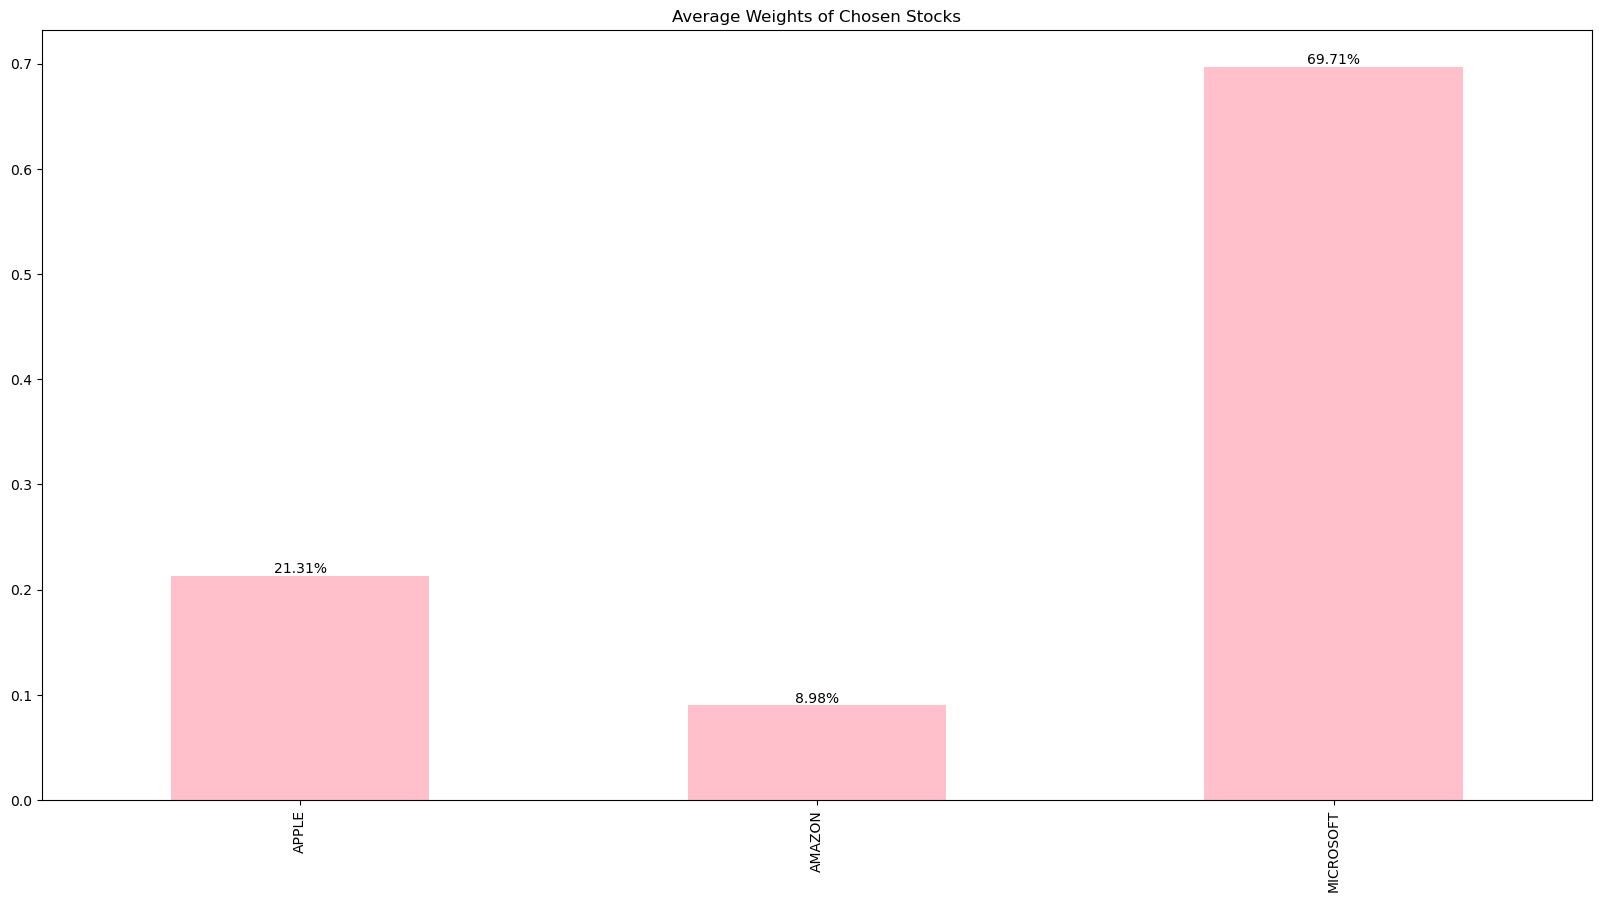

In [19]:
# Plotting the average weights
average_weights_series = pd.Series(average_weights_optimized, index=stock_tickers)
ax = average_weights_series.plot.bar(figsize=(20, 10), color='pink', title='Average Weights of Chosen Stocks')

# Adding hover information to the plot
for i, val in enumerate(average_weights_optimized):
    plt.text(i, val, f'{val:.2%}', ha='center', va='bottom')

# Adding custom tick labels
plt.xticks(range(len(stock_tickers)), ['APPLE', 'AMAZON', 'MICROSOFT'])

# Adding exact weight information using mplcursors
cursor = mplcursors.cursor(ax, hover=True)
cursor.connect("add", lambda sel: sel.annotation.set_text(f"Weight: {sel.artist.get_height():.2%}"))

# Show the plot
plt.show()

### Time Series Plot: Rolling Mean of Each Stock 

The purpose is to visualize the trends/patterns in the simulated prices for each stock over time

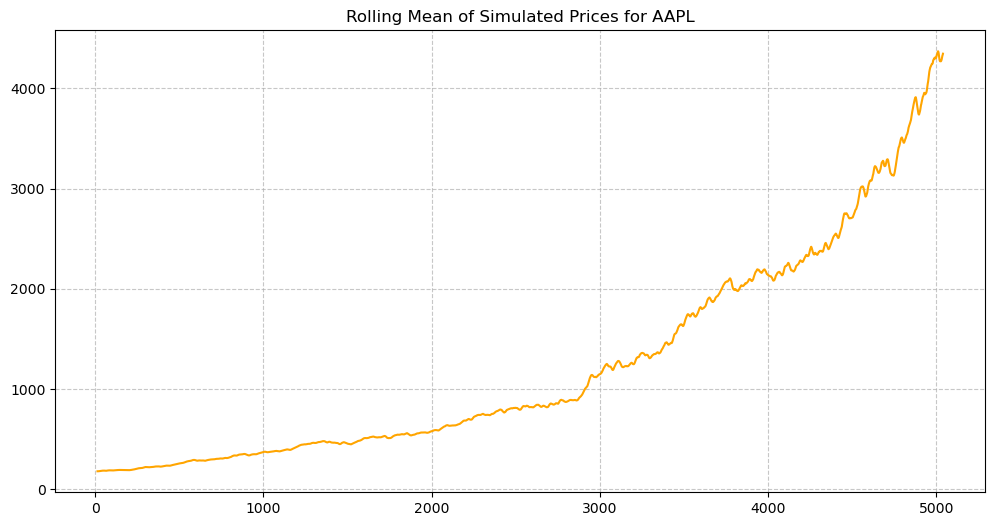

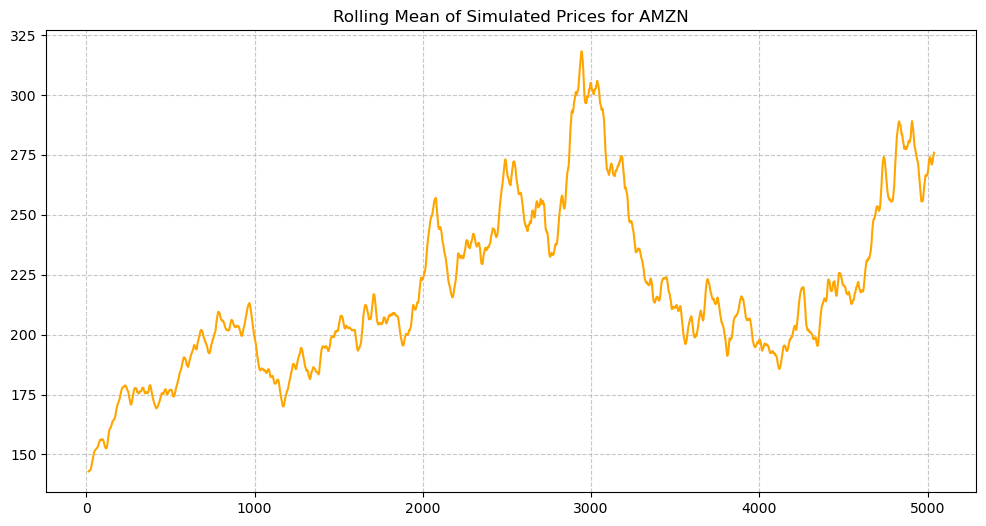

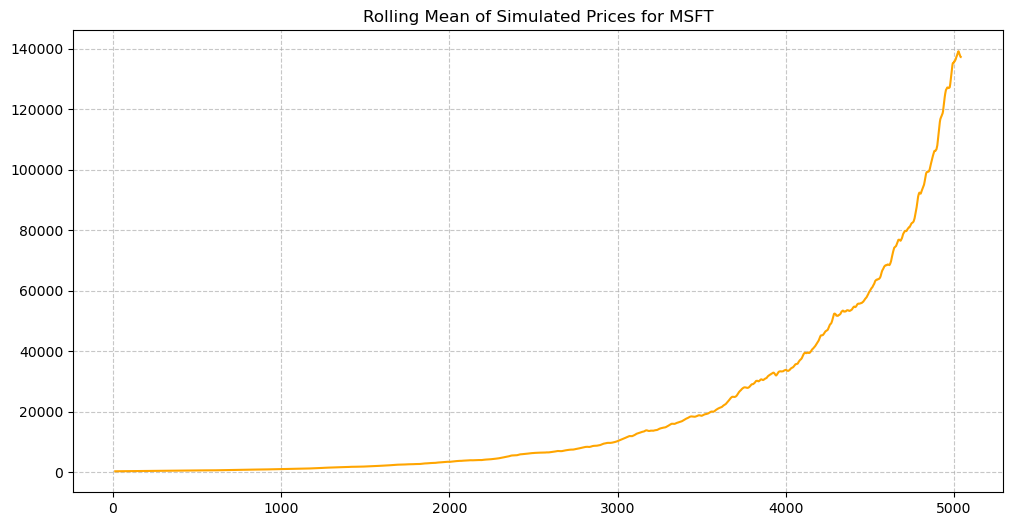

In [42]:
for stock in stock_tickers:
    plt.figure(figsize=(12, 6))  # Adjusted the figure size

    # Calculate the rolling mean
    rolling_mean = simulated_prices_stocks[stock].mean(axis=1).rolling(window=15).mean()

    # Plot the rolling mean with a different color (orange)
    plt.plot(rolling_mean, color='orange')

    # Add labels and title
    plt.title(f"Rolling Mean of Simulated Prices for {stock}")

    # Customize the appearance of the plot
    plt.grid(True, linestyle='--', alpha=0.7)  # Add grid lines with dashed style for better readability 

    # Show or save the plot
    plt.show()


### Monte Carlo Simulations Vs. Optimized Simulations

#### 50 Monte Carlo Simulations Plot

<Figure size 2000x3000 with 0 Axes>

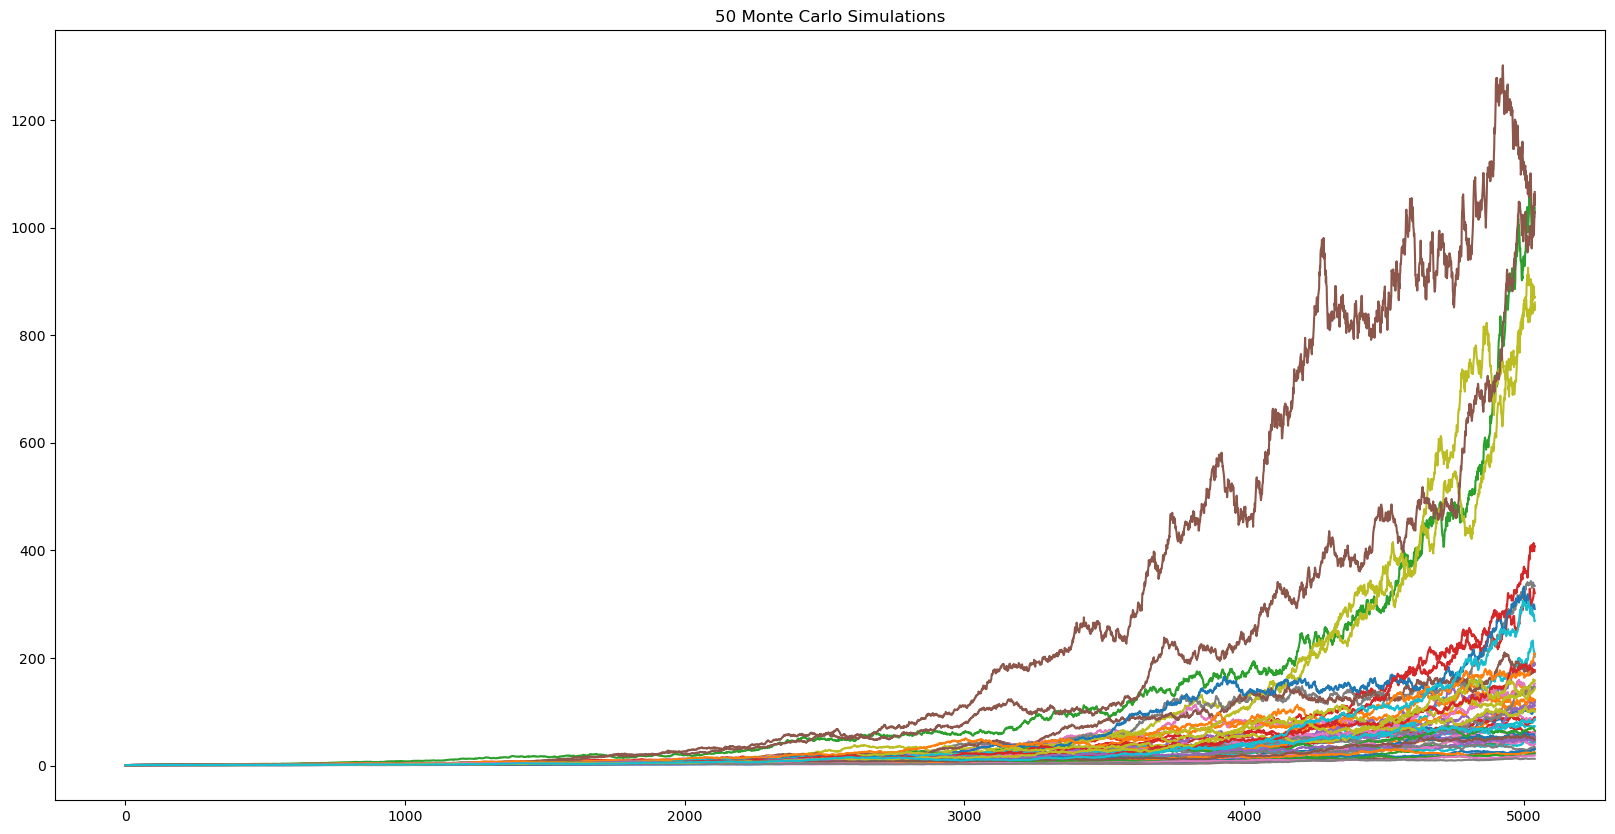

In [20]:
# Setting figure size
plt.figure(figsize=(20, 30))

# Plotting the DataFrame
monte_carlo_results.plot(legend=None, title=f'{num_sims} Monte Carlo Simulations', figsize=(20, 10))

# Show the plot
plt.show()

#### 50 Optimized Monte Carlo Simulations Plot

<Figure size 2000x3000 with 0 Axes>

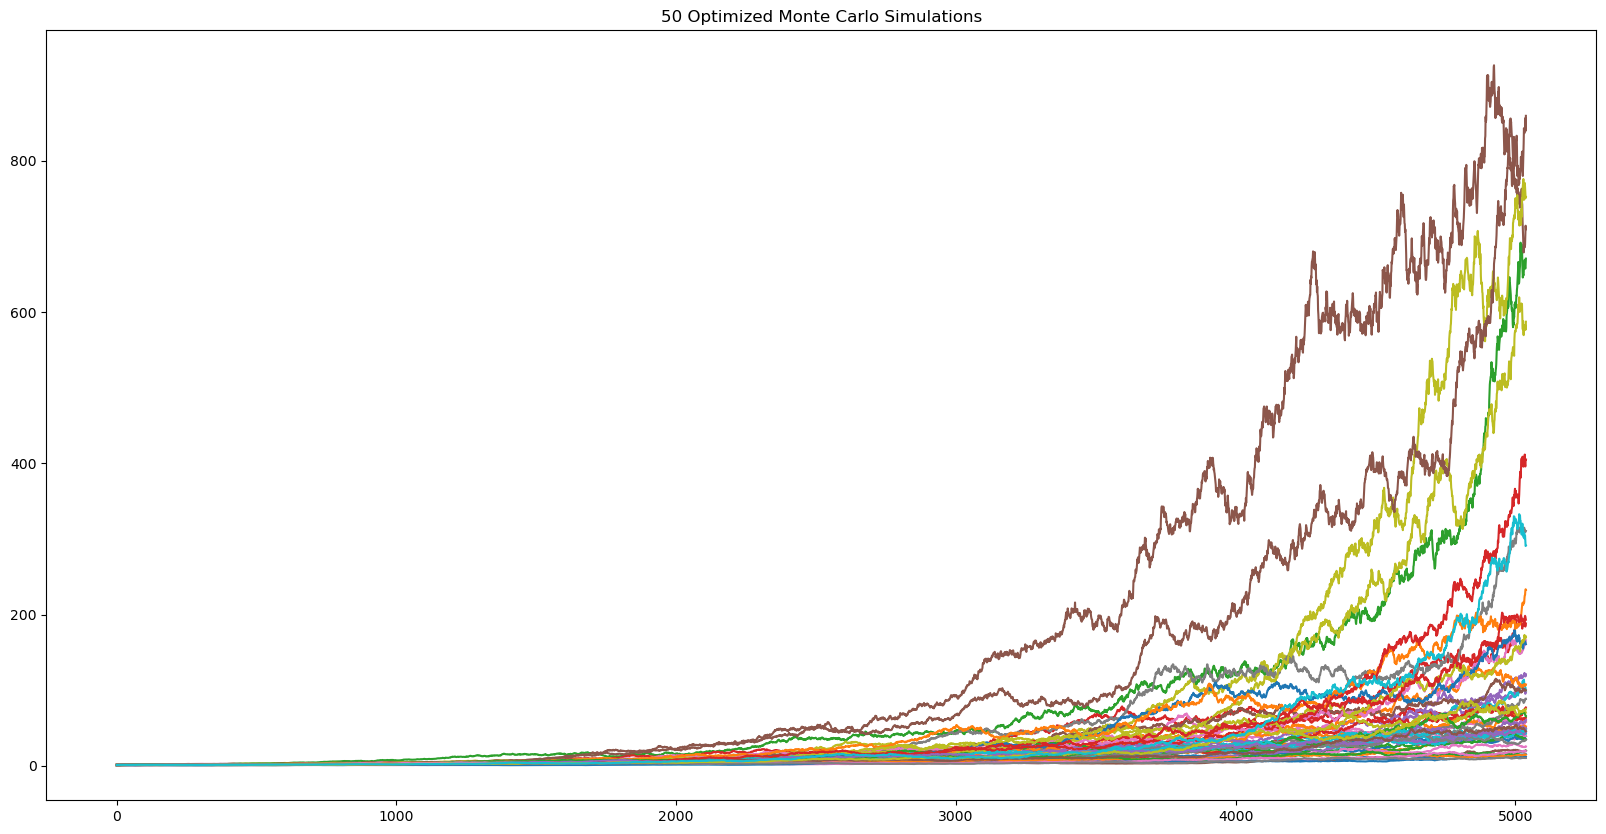

In [21]:
# Setting figure size
plt.figure(figsize=(20, 30))

# Plotting the DataFrame
monte_carlo_results_custom.plot(legend=None, title=f'{num_sims} Optimized Monte Carlo Simulations', figsize=(20, 10))

# Show the plot
plt.show()

### Average Return On Investment After 50 Years

In [22]:
monte_carlo_results_custom.iloc[-1]

0      48.637247
1      58.078885
2     670.790121
3      63.655986
4      97.178244
5     709.673235
6      59.170435
7      50.878386
8     752.458686
9      99.738601
10     11.847515
11     52.084617
12     39.108174
13    193.146644
14    121.019715
15     20.052676
16     39.416775
17    310.515888
18    587.327302
19     42.523549
20     34.906337
21    107.542163
22     35.131296
23     77.082637
24     60.580198
25     99.805242
26    166.020668
27     88.493260
28     70.261768
29     43.602072
30    160.786223
31    232.716829
32     65.316117
33    405.203727
34     44.873176
35    859.655095
36     25.601637
37     34.062540
38    170.939454
39     47.839038
40     15.314773
41     14.571170
42     19.888194
43    188.221077
44     49.256738
45     45.701338
46     19.288469
47     10.182597
48     74.965792
49    291.141183
Name: 5038, dtype: float64

### Approximated Return On Investment 

In [25]:
# Get the cumulative returns of the portfolio from the last simulation
recentReturns = monte_carlo_results_custom.iloc[-1]

# Calculate the average of the recent returns and estimate the expected value of the investment
average_expected_return = recentReturns.mean() * initial_investment

# Print the expected investment value based on the average returns with a comma for thousands separator
print(f'With an initial investment of ${initial_investment:,.2f}, the expected portfolio value with average optimized weights of chosen stocks is approximately: ${average_expected_return:,.2f}')


With an initial investment of $1,000.00, the expected portfolio value with average optimized weights of chosen stocks is approximately: $151,725.07


In [26]:
# Get the cumulative returns of the portfolio from the last simulation
recentReturns_uniform = uniform_portfolio_results_custom.iloc[-1]

# Calculate the average of the recent returns and estimate the expected value of the investment
average_expected_return = recentReturns_uniform.mean() * initial_investment

# Print the expected investment value based on the average returns with a comma for thousands separator
print(f'With an initial investment of ${initial_investment:,.2f}, the expected portfolio value with uniform weights of chosen stocks is approximately: ${average_expected_return:,.2f}')


With an initial investment of $1,000.00, the expected portfolio value with uniform weights of chosen stocks is approximately: $37,385.97


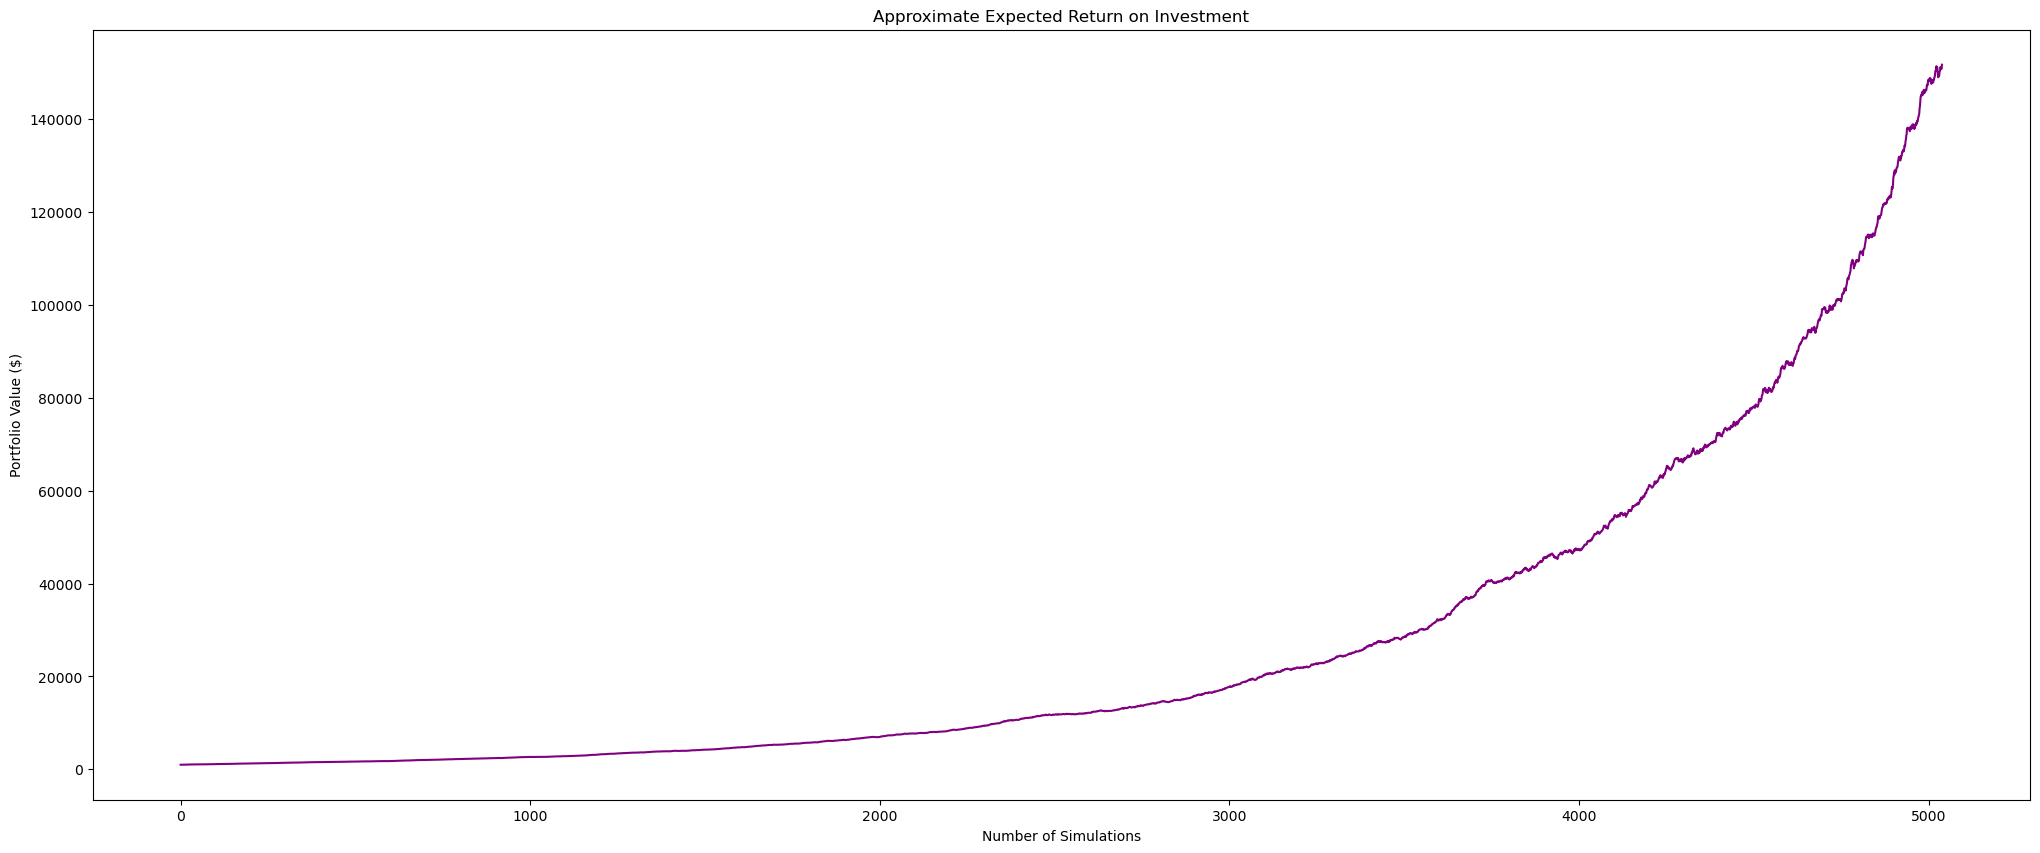

In [27]:
(monte_carlo_results_custom.mean(axis=1) * initial_investment).plot(figsize=(25, 10), color='purple')

# Add a title and axis labels
plt.title('Approximate Expected Return on Investment')
plt.xlabel('Number of Simulations')
plt.ylabel('Portfolio Value ($)')

# Show the plot
plt.show()

### Average Optimal Weights Simulations Vs. Uniform Weights Simulation

#### Average Optimal Weights Plot

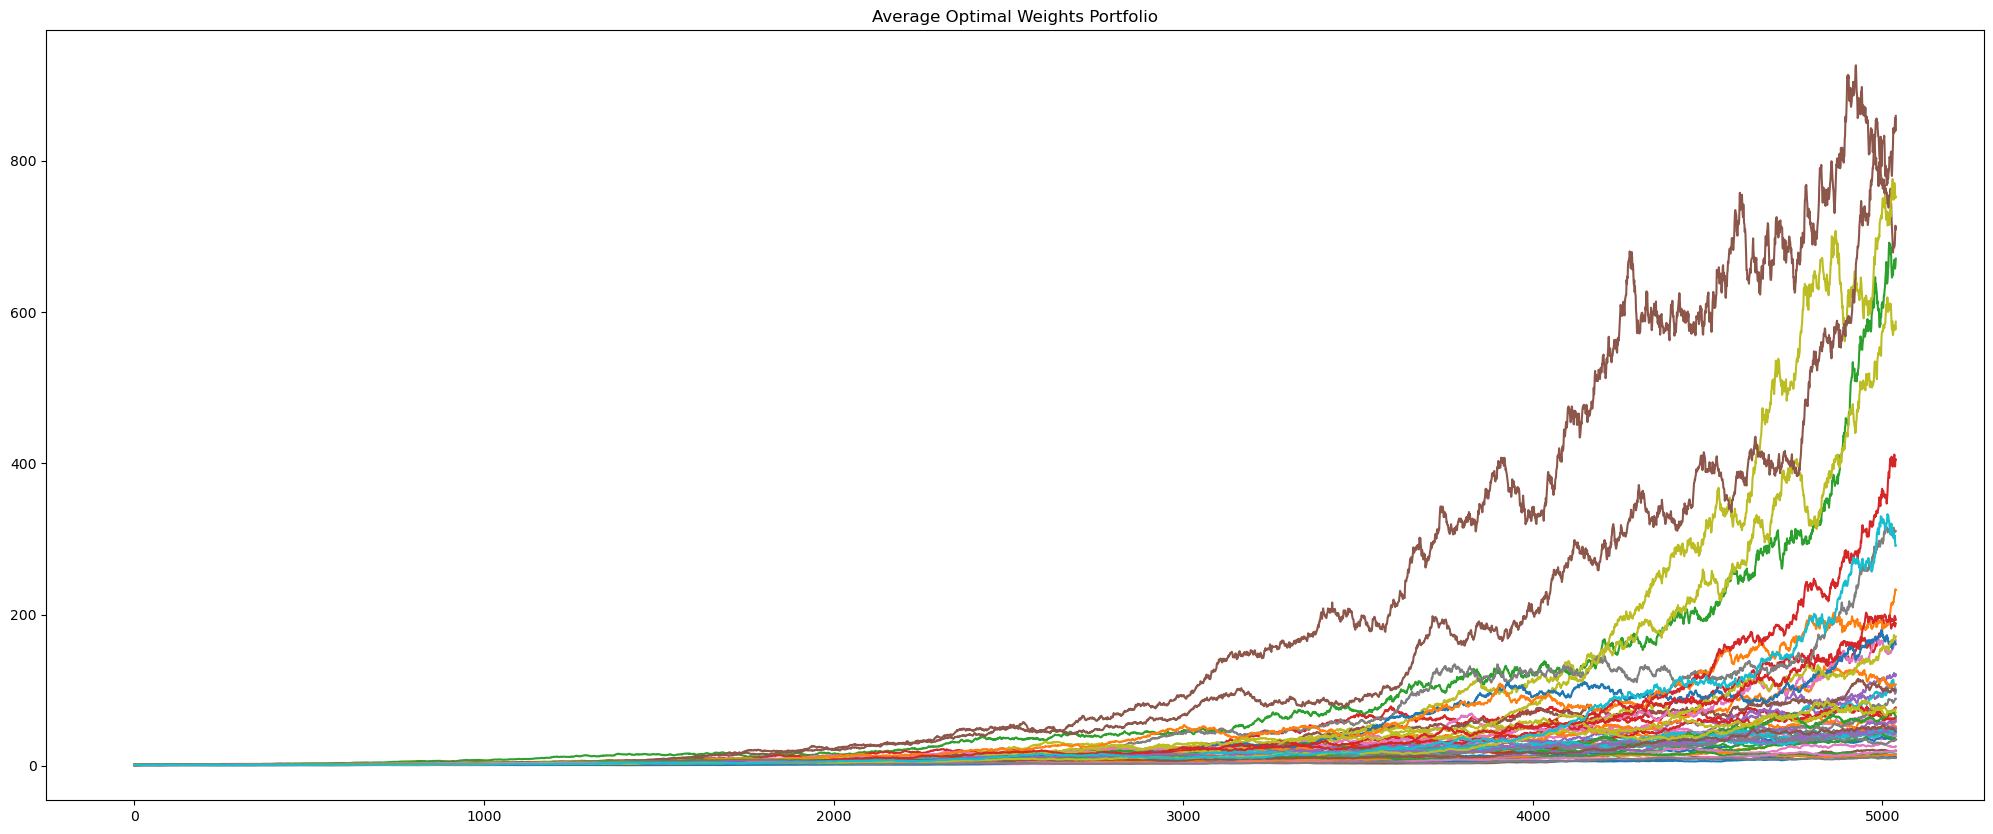

In [28]:
monte_carlo_results_custom.plot(title='Average Optimal Weights Portfolio', figsize=(25, 10), legend=None)

# Show the plot
plt.show()

#### Uniform Weights Plot

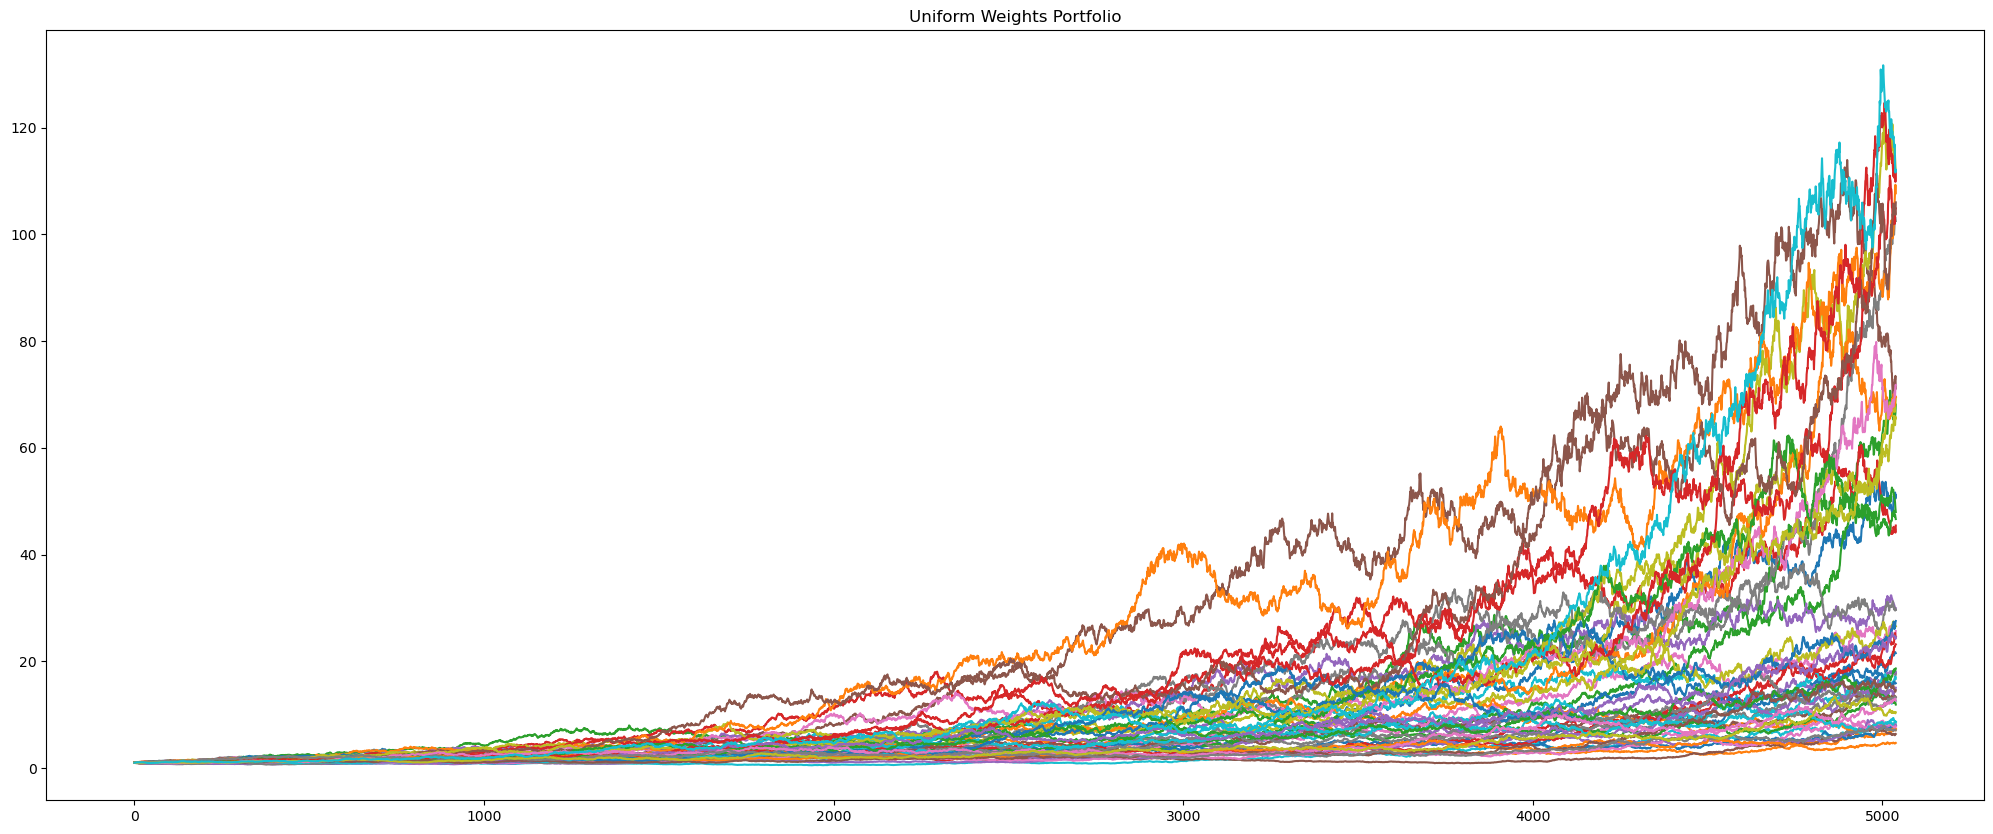

In [29]:
uniform_portfolio_results_custom.plot(title='Uniform Weights Portfolio', figsize=(25, 10), legend=None)

# Show the plot
plt.show()

### Average Optimal Weights Vs. S&P500 Simulations

#### S&P500 Monte Carlo Simulations

<Axes: title={'center': 'S&P500 simulations'}>

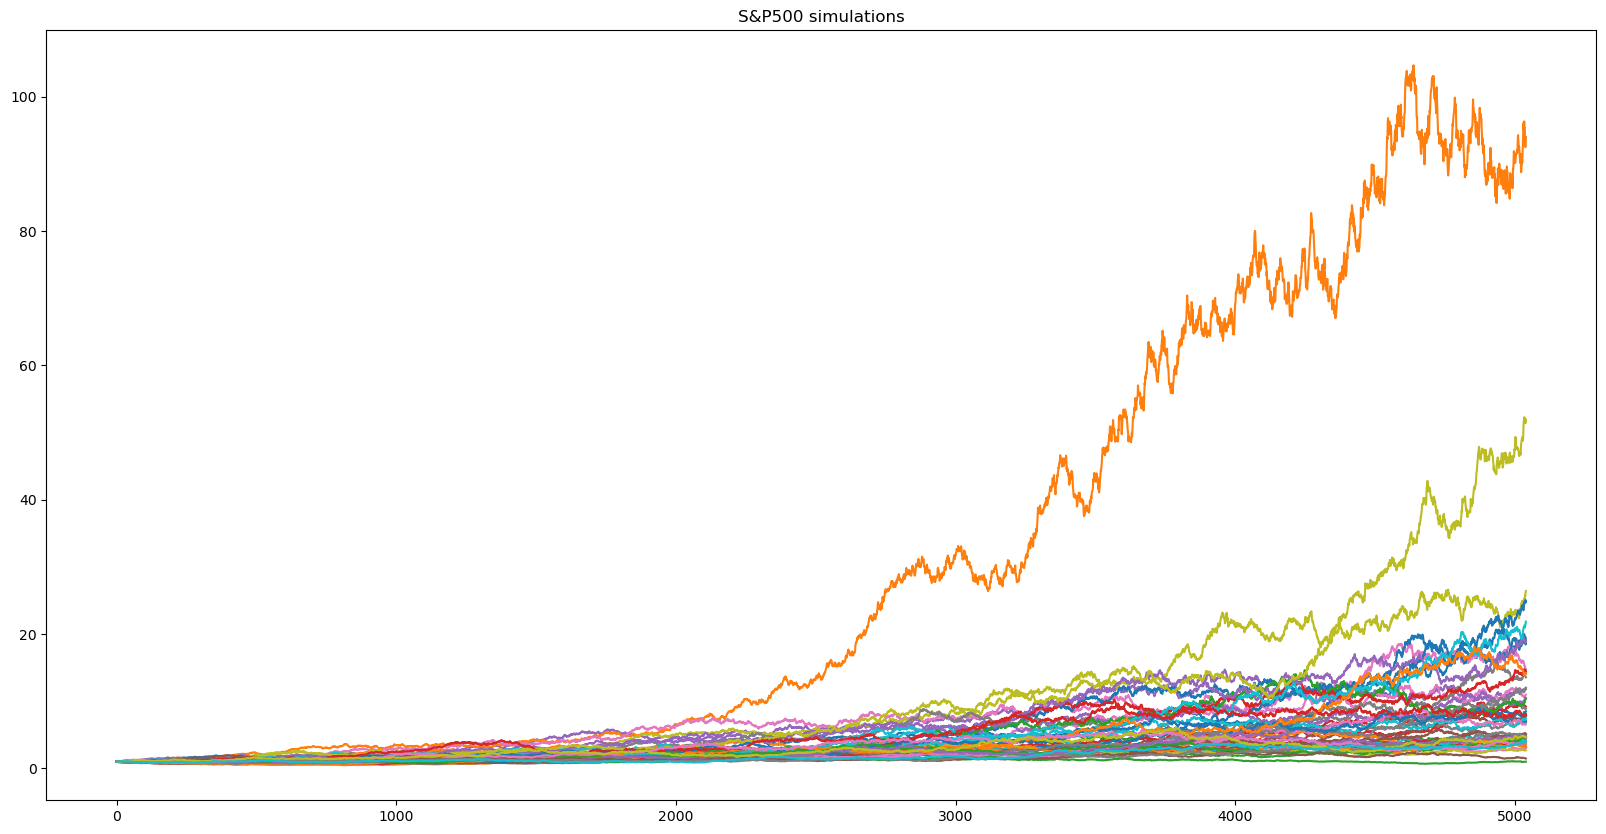

In [30]:
monte_carlo_spy_results.plot(title='S&P500 simulations', figsize=(20,10), legend = None)

#### Average Optimal Weights Plot

<Axes: title={'center': 'Average Optimal Weights Portfolio'}>

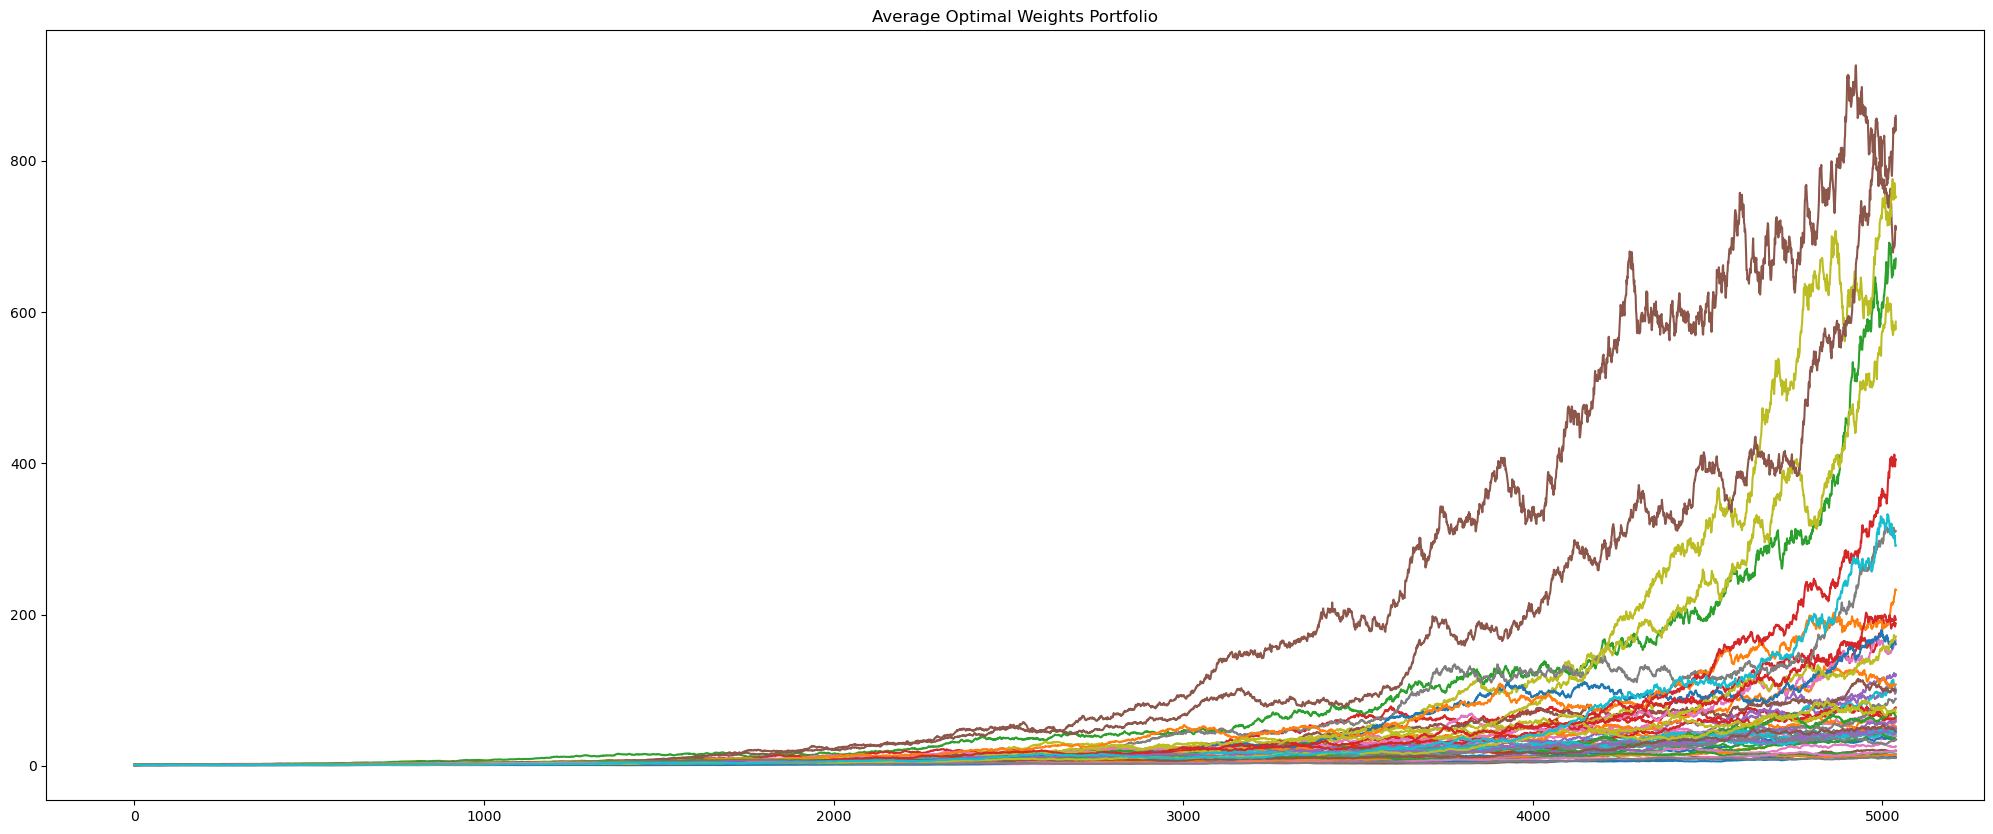

In [31]:
monte_carlo_results_custom.plot(title='Average Optimal Weights Portfolio', figsize=(25, 10), legend=None)

### Confidence Interval Visualization

In [32]:
# Calculate the 5th and 95th percentiles of the recentReturns dataset
confidence_interval = recentReturns.quantile([0.05, 0.95])

# Display the calculated confidence interval
confidence_interval

0.05     14.905791
0.95    692.175834
Name: 5038, dtype: float64


The 90% confidence interval for the values in the recentReturns dataset is approximately [14.91, 692.18]. This means that there is a 90% confidence that the true values lie within this range

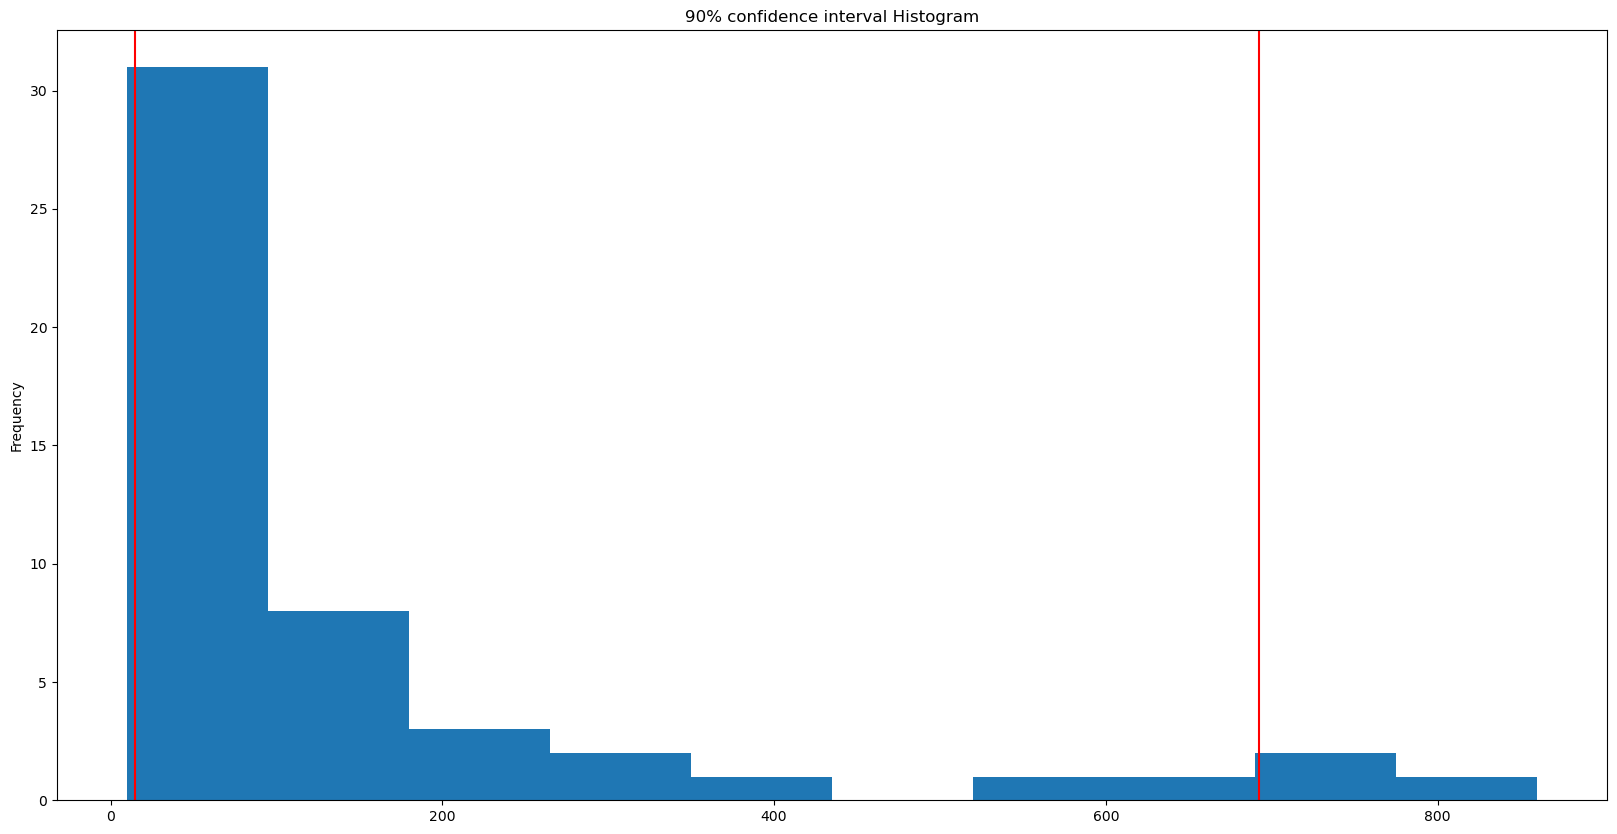

In [33]:
# Creating a new figure for the plot
plt.figure()

# Plot a histogram of the recentReturns dataset
recentReturns.plot.hist(title="90% confidence interval Histogram", figsize=(20, 10))

# Add a vertical red line at the 5th percentile (lower boundary of the confidence interval)
plt.axvline(confidence_interval.iloc[0], color='r')

# Add a vertical red line at the 95th percentile (upper boundary of the confidence interval)
plt.axvline(confidence_interval.iloc[1], color='r')
